<a href="https://colab.research.google.com/github/apkmannava/machine_learning_apk/blob/main/P2_Digit_Recognition_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import libraries

In [ ]:
import tensorflow as tf
from sklearn.svm import LinearSVC
from sklearn.metrics import zero_one_loss
import math
# import numpy as np
import pickle, gzip, numpy as np

import scipy.sparse as sparse

import matplotlib.pyplot as plt
import matplotlib.cm as cm


# load data

In [ ]:
# Load MNIST data:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train/255.
x_test  = x_test/255.

print('''x_train:{},y_train: {}
x_test :{},y_test : {}'''.format(x_train.shape,y_train.shape,x_test.shape,y_test.shape))

11490434/11490434 [==============================] - 0s 0us/step
x_train:(60000, 28, 28),y_train: (60000,)
x_test :(10000, 28, 28),y_test : (10000,)


# plot data

In [ ]:
def plot_images_from_data(train_images,train_labels):
    image_rows = 4
    image_cols = 5
    rand_imag_array = np.random.randint(0,len(train_images),image_rows*image_cols)
    plt.figure(figsize=(2*image_rows,1*image_cols))
    for i in range(image_rows*image_cols):
        plt.subplot(image_rows,image_cols,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_images[i], cmap=plt.cm.binary)
        # plt.xlabel(class_names[train_labels[i]],color='blue',backgroundcolor='white')

    plt.tight_layout()
    plt.show()
    return

In [ ]:
def plot_images(X):
    if X.ndim == 1:
        X = np.array([X])
    num_images = X.shape[0]
    num_rows = math.floor(math.sqrt(num_images))
    num_cols = math.ceil(num_images/num_rows)
    for i in range(num_images):
        reshaped_image = X[i,:].reshape(28,28)
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(reshaped_image, cmap = cm.Greys_r)
        plt.axis('off')
    plt.show()

# get MNIST data

In [ ]:
def get_MNIST_data():
    """
    Reads mnist dataset from file

    Returns:
        train_x - 2D Numpy array (n, d) where each row is an image
        train_y - 1D Numpy array (n, ) where each row is a label
        test_x  - 2D Numpy array (n, d) where each row is an image
        test_y  - 1D Numpy array (n, ) where each row is a label

    """
    (train_x, train_y), (test_x, test_y)= tf.keras.datasets.mnist.load_data()
    train_x = train_x/255.
    test_x  = test_x/255.

    # In this code, we start with an original array of size (n, r, c).
    # We create a random array with that size using np.random.random.
    # To reshape the array, we use the reshape function. The first argument to reshape is the desired shape (n, r*c).
    # To determine the second dimension, we use -1,
    # which instructs NumPy to automatically determine the appropriate size based on the other dimensions.

    train_x = train_x.reshape(train_x.shape[0], -1)
    test_x  =  test_x.reshape( test_x.shape[0], -1)

    return (train_x, train_y, test_x, test_y)

# linear Regression

## Closed Form Solution of LInear Regression

$
    \theta = ({X^T}X + {\lambda}I)^{-1} {{X^T} Y}
$

## emperical risk for Linear Regression


$$
    R_n(\theta)= \frac{1}{n} \sum_{i=1}^{n}[{\frac{({y^{(i)}-\theta\bullet x^{(i)}})^2}{2}}]
$$

$$
    \nabla_{\theta}({\frac{(y-\theta\bullet x^{(i)})^2}{2}})
$$

$$
    = -(y-\theta \bullet x^{(i)})\bullet x^{(i)}
$$

$$
   = -y\bullet x^{(i)}+\theta\bullet (x^{(i)})^{2}
$$

equate the above to zero

$$
    -y\bullet x^{(i)}+\theta\bullet (x^{(i)})^{2}=0
$$

$$
    y\bullet x^{(i)}=\theta\bullet (x^{(i)})^{2}
$$

$$
    \theta = \frac{(y\bullet x^{(i)})}{(x^{(i)})^{2}}
$$

keeping the above in matrix form  ( and adding  $ \lambda $ learing rate )

$$
    \theta = ({X^T}X + {\lambda}I)^{-1} {{X^T} Y}
$$

In [ ]:
def closed_form(X, Y, lambda_factor):
    """
    function Definition: gives closed form solution of linear regression with L2 regularization

    Args:
        X - (n, d + 1) NumPy array (n datapoints each with d features plus the bias feature in the first dimension)
        Y - (n, ) NumPy array containing the labels (a number from 0-9) for each
            data point
        lambda_factor - the regularization constant (scalar)
    Returns:
        theta - (d + 1, ) NumPy array containing the weights of linear regression. Note that theta[0]
        represents the y-axis intercept of the model and therefore X[0] = 1
    """
    theta=np.matmul(X.T,X)
    I=np.eye(np.max(tuple(theta.shape)))
    theta=theta+(lambda_factor*I)
    theta=np.linalg.inv(theta)
    theta=np.matmul(theta,X.T)
    theta=np.matmul(theta,Y)
    return theta

## Test Error on Linear Regression
Apply the linear regression model on the test set. For classification purpose, you decide to round the predicted label into numbers 0-9.


In [ ]:
def compute_test_error_linear(test_x, Y, theta):
    test_y_predict = np.round(np.dot(test_x, theta))
    # print(test_y_predict[:20])

    test_y_predict[test_y_predict < 0] = 0
    test_y_predict[test_y_predict > 9] = 9

    # print(test_y_predict[:20])
    return 1 - np.mean(test_y_predict == Y)


## 2. Linear Regression with Closed Form Solution

In [ ]:
# TODO: first fill out functions in linear_regression.py, or the below functions will not work

def run_linear_regression_on_MNIST(lambda_factor):
    """
    Trains linear regression, classifies test data, computes test error on test set

    Returns:
        Final test error
    """
    # Load MNIST data:
    (train_x, train_y,test_x, test_y) = get_MNIST_data()


    # np.ones([train_x.shape[0], 1]): This creates a 2D NumPy array consisting of ones.
    #                                 The number of rows in this array is determined by the shape of train_x,
    #                                 specifically train_x.shape[0], and it has only one column.

    # np.hstack([np.ones([train_x.shape[0], 1]), train_x]): This horizontally stacks the ones array (bias term)
    #                                                     with the train_x array. The hstack function concatenates arrays along
    #                                                     the horizontal axis. By doing this, the bias term is added as the first column
    #                                                     to each row of train_x.

    train_x_bias = np.hstack([np.ones([train_x.shape[0], 1]), train_x])
    test_x_bias = np.hstack([np.ones([test_x.shape[0], 1]), test_x])
    theta = closed_form(train_x_bias, train_y, lambda_factor)
    test_error = compute_test_error_linear(test_x_bias, test_y, theta)
    return test_error

# Support vector Machine

## One Vs. Rest SVM

In [ ]:
def one_vs_rest_svm(train_x, train_y, test_x):
    """
    Trains a linear SVM for binary classifciation

    Args:
        train_x - (n, d) NumPy array (n datapoints each with d features)
        train_y - (n, ) NumPy array containing the labels (0 or 1) for each training data point
        test_x - (m, d) NumPy array (m datapoints each with d features)
    Returns:
        pred_test_y - (m,) NumPy array containing the labels (0 or 1) for each test data point
    """
    clf=LinearSVC(random_state=0,C=0.1,multi_class='ovr')
    clf.fit(train_x,train_y)
    pred_test_y=clf.predict(test_x)
    return pred_test_y

## compute_test_error_svm

In [ ]:
def compute_test_error_svm(test_y, pred_test_y):
    return zero_one_loss(test_y, pred_test_y)

## run_svm_one_vs_rest_on_MNIST

In [ ]:
def run_svm_one_vs_rest_on_MNIST():
    """
    Trains svm, classifies test data, computes test error on test set

    Returns:
        Test error for the binary svm
    """
    train_x, train_y, test_x, test_y = get_MNIST_data()
    train_y[train_y != 0] = 1
    test_y[test_y != 0] = 1
    pred_test_y = one_vs_rest_svm(train_x, train_y, test_x)
    test_error = compute_test_error_svm(test_y, pred_test_y)
    return test_error

## multi_class_svm

In [ ]:
def multi_class_svm(train_x, train_y, test_x):
    """
    Trains a linear SVM for multiclass classifciation using a one-vs-rest strategy

    Args:
        train_x - (n, d) NumPy array (n datapoints each with d features)
        train_y - (n, ) NumPy array containing the labels (int) for each training data point
        test_x - (m, d) NumPy array (m datapoints each with d features)
    Returns:
        pred_test_y - (m,) NumPy array containing the labels (int) for each test data point
    """
    clf=LinearSVC(random_state=0,C=0.1,multi_class='ovr')
    clf.fit(train_x,train_y)
    pred_test_y=clf.predict(test_x)
    return pred_test_y

## run_multiclass_svm_on_MNIST

In [ ]:
def run_multiclass_svm_on_MNIST():
    """
    Trains svm, classifies test data, computes test error on test set

    Returns:
        Test error for the binary svm
    """
    train_x, train_y, test_x, test_y = get_MNIST_data()
    pred_test_y = multi_class_svm(train_x, train_y, test_x)
    test_error = compute_test_error_svm(test_y, pred_test_y)
    return test_error

# Softmax

## augment_feature_vector

In [ ]:
def augment_feature_vector(X):
    """
    Adds the x[i][0] = 1 feature for each data point x[i].

    Args:
        X - a NumPy matrix of n data points, each with d - 1 features

    Returns: X_augment, an (n, d) NumPy array with the added feature for each datapoint
    """
    column_of_ones = np.zeros([len(X), 1]) + 1
    return np.hstack((column_of_ones, X))

## compute_probabilities

In [ ]:
def compute_probabilities(X, theta, temp_parameter):
    """
    Computes, for each datapoint X[i], the probability that X[i] is labeled as j
    for j = 0, 1, ..., k-1

    Args:
        X - (n, d) NumPy array (n datapoints each with d features)
        theta - (k, d) NumPy array, where row j represents the parameters of our model for label j
        temp_parameter - the temperature parameter of softmax function (scalar)
    Returns:
        H - (k, n) NumPy array, where each entry H[j][i] is the probability that X[i] is labeled as j
    """
    #YOUR CODE HERE
    H=np.zeros(len(theta)*len(X)).reshape(len(theta),len(X))
    sum_1=np.zeros(len(X))
    H=np.matmul(theta,X.T)
    H=H/temp_parameter
    for i in range(len(X)):
        H[:,i]=H[:,i]-np.max(H[:,i])

    H=np.exp(H)
    for i in range(len(X)):
        sum_1[i]=np.sum(H[:,i])

    H=H/sum_1
    return H

## compute_cost_function

In [ ]:
def compute_cost_function(X, Y, theta, lambda_factor, temp_parameter):
    """
    Computes the total cost over every datapoint.

    Args:
        X - (n, d) NumPy array (n datapoints each with d features)
        Y - (n, ) NumPy array containing the labels (a number from 0-9) for each
            data point
        theta - (k, d) NumPy array, where row j represents the parameters of our
                model for label j
        lambda_factor - the regularization constant (scalar)
        temp_parameter - the temperature parameter of softmax function (scalar)

    Returns
        c - the cost value (scalar)
    """
    #YOUR CODE HERE
    A=np.clip(compute_probabilities(X,theta,temp_parameter),1e-15, 1-1e-15)
    B=np.log(A)

    sum1=0
    sum_theta=0
    n=len(X)
    k=len(theta)
    d=len(theta)
#     M = sparse.coo_matrix(([1]*n, (Y, range(n))), shape=(k,n)).toarray()
    need_matrix=sparse.coo_matrix(([1]*n,(Y, range(n))),shape=(k,n)).toarray()

    sum_theta=sum_theta+np.sum(theta**2)

    sum1=need_matrix*B
    sum_theta=theta**2

    a=np.sum(sum1)
    b=np.sum(sum_theta)

    a=a*(-1/len(X))
    b=b*(lambda_factor/2)
    c=a+b
    return c

## run_gradient_descent_iteration

In [ ]:
def run_gradient_descent_iteration(X, Y, theta, alpha, lambda_factor, temp_parameter):
    """
    Runs one step of batch gradient descent

    Args:
        X - (n, d) NumPy array (n datapoints each with d features)
        Y - (n, ) NumPy array containing the labels (a number from 0-9) for each
            data point
        theta - (k, d) NumPy array, where row j represents the parameters of our
                model for label j
        alpha - the learning rate (scalar)
        lambda_factor - the regularization constant (scalar)
        temp_parameter - the temperature parameter of softmax function (scalar)

    Returns:
        theta - (k, d) NumPy array that is the final value of parameters theta
    """
    #YOUR CODE HERE

    P=np.clip(compute_probabilities(X,theta,temp_parameter),1e-15, 1-1e-15)
    n=len(Y)
#    k=len(P)
    k=len(theta)
    d=len(theta)
#    M = sparse.coo_matrix(([1]*n, (Y, range(n))), shape=(k,n)).toarray()
#    M = sparse.coo_matrix(([1]*n, (Y, range(n))), shape=(d,n)).toarray()
    I=np.identity(theta.shape[0])
    Y=Y.squeeze()
    M=I[:,Y]
    M1=M-P
    M1=np.matmul(M1,X)
    M1=M1/(-1*temp_parameter*n)
    M2=lambda_factor*theta

    theta_new =M1+M2
    theta=theta-(alpha*theta_new)
    return theta

## softmax_regression

In [ ]:
def softmax_regression(X, Y, temp_parameter, alpha, lambda_factor, k, num_iterations):
    """
    Runs batch gradient descent for a specified number of iterations on a dataset
    with theta initialized to the all-zeros array. Here, theta is a k by d NumPy array
    where row j represents the parameters of our model for label j for
    j = 0, 1, ..., k-1

    Args:
        X - (n, d - 1) NumPy array (n data points, each with d-1 features)
        Y - (n, ) NumPy array containing the labels (a number from 0-9) for each
            data point
        temp_parameter - the temperature parameter of softmax function (scalar)
        alpha - the learning rate (scalar)
        lambda_factor - the regularization constant (scalar)
        k - the number of labels (scalar)
        num_iterations - the number of iterations to run gradient descent (scalar)

    Returns:
        theta - (k, d) NumPy array that is the final value of parameters theta
        cost_function_progression - a Python list containing the cost calculated at each step of gradient descent
    """
    X = augment_feature_vector(X)
    theta = np.zeros([k, X.shape[1]])
    cost_function_progression = []
    for i in range(num_iterations):
        cost_function_progression.append(compute_cost_function(X, Y, theta, lambda_factor, temp_parameter))
        theta = run_gradient_descent_iteration(X, Y, theta, alpha, lambda_factor, temp_parameter)
    return theta, cost_function_progression

## plot_cost_function_over_time

In [ ]:
def plot_cost_function_over_time(cost_function_history):
    plt.plot(range(len(cost_function_history)), cost_function_history)
    plt.ylabel('Cost Function')
    plt.xlabel('Iteration number')
    plt.show()

## get_classification

In [ ]:
def get_classification(X, theta, temp_parameter):
    """
    Makes predictions by classifying a given dataset

    Args:
        X - (n, d - 1) NumPy array (n data points, each with d - 1 features)
        theta - (k, d) NumPy array where row j represents the parameters of our model for
                label j
        temp_parameter - the temperature parameter of softmax function (scalar)

    Returns:
        Y - (n, ) NumPy array, containing the predicted label (a number between 0-9) for
            each data point
    """
    X = augment_feature_vector(X)
    probabilities = compute_probabilities(X, theta, temp_parameter)
    return np.argmax(probabilities, axis = 0)

## compute_test_error

In [ ]:
def compute_test_error(X, Y, theta, temp_parameter):
    error_count = 0.
    assigned_labels = get_classification(X, theta, temp_parameter)
    return 1 - np.mean(assigned_labels == Y)

## write_pickle_data

In [ ]:
def write_pickle_data(data, file_name):
    f = gzip.open(file_name, 'wb')
    pickle.dump(data, f)
    f.close()

## update_y

In [ ]:
def update_y(train_y, test_y):
    """
    Changes the old digit labels for the training and test set for the new (mod 3)
    labels.

    Args:
        train_y - (n, ) NumPy array containing the labels (a number between 0-9)
                 for each datapoint in the training set
        test_y - (n, ) NumPy array containing the labels (a number between 0-9)
                for each datapoint in the test set

    Returns:
        train_y_mod3 - (n, ) NumPy array containing the new labels (a number between 0-2)
                     for each datapoint in the training set
        test_y_mod3 - (n, ) NumPy array containing the new labels (a number between 0-2)
                    for each datapoint in the test set
    """
    #YOUR CODE HERE
    train_y_mod3=train_y%3
    test_y_mod3=test_y%3
    return train_y_mod3,test_y_mod3

## compute_test_error_mod3

In [ ]:
def compute_test_error_mod3(X, Y, theta, temp_parameter):
    """
    Returns the error of these new labels when the classifier predicts the digit. (mod 3)

    Args:
        X - (n, d - 1) NumPy array (n datapoints each with d - 1 features)
        Y - (n, ) NumPy array containing the labels (a number from 0-2) for each
            data point
        theta - (k, d) NumPy array, where row j represents the parameters of our
                model for label j
        temp_parameter - the temperature parameter of softmax function (scalar)

    Returns:
        test_error - the error rate of the classifier (scalar)
    """
    #YOUR CODE HERE
    Y_all=get_classification(X, theta, temp_parameter)
    Y_all=Y_all%3
    compute_test_error_mod3 = 1 - np.mean(Y_all == Y)
    return compute_test_error_mod3

## run_softmax_on_MNIST

In [ ]:
def run_softmax_on_MNIST(temp_parameter=1.):
    """
    Trains softmax, classifies test data, computes test error, and plots cost function

    Runs softmax_regression on the MNIST training set and computes the test error using
    the test set. It uses the following values for parameters:
    alpha = 0.3
    lambda = 1e-4
    num_iterations = 150

    Saves the final theta to ./theta.pkl.gz

    Returns:
        Final test error
    """
    train_x, train_y, test_x, test_y = get_MNIST_data()
    theta, cost_function_history = softmax_regression(train_x, train_y, temp_parameter, alpha= 0.3, lambda_factor = 1.0e-4, k = 10, num_iterations = 150)
    plot_cost_function_over_time(cost_function_history)
    test_error = compute_test_error(test_x, test_y, theta, temp_parameter)
    # Save the model parameters theta obtained from calling softmax_regression to disk.
    write_pickle_data(theta, "./theta.pkl.gz")

    # "Using the Current Model"
    train_y_mod3,test_y_mod3=update_y(train_y, test_y)
    #    compute_test_error_mod3(X, Y, theta, temp_parameter):
    test_error_mod3=compute_test_error_mod3(test_x, test_y_mod3, theta, temp_parameter)
    #      and print the test_error_mod3
    print('softmax_test_error_mod3=',test_error_mod3)
    return test_error

In [ ]:
def run_softmax_on_MNIST_mod3(temp_parameter=1):
    """
    Trains Softmax regression on digit (mod 3) classifications.

    See run_softmax_on_MNIST for more info.
    """
    #YOUR CODE HERE
    train_x, train_y, test_x, test_y = get_MNIST_data()
    train_y_mod3,test_y_mod3=update_y(train_y, test_y)
    theta, cost_function_history = softmax_regression(train_x, train_y_mod3, temp_parameter, alpha= 0.3, lambda_factor = 1.0e-4, k = 10, num_iterations = 150)
    plot_cost_function_over_time(cost_function_history)
    test_error = compute_test_error(test_x, test_y_mod3, theta, temp_parameter)
    test_error_mod3=compute_test_error_mod3(test_x, test_y_mod3, theta, temp_parameter)
    # Save the model parameters theta obtained from calling softmax_regression to disk.
    write_pickle_data(theta, "./theta.pkl.gz")
    print('softmax_test_error_mod3=',test_error_mod3)
    return test_error

# PCA

## center_data

In [ ]:
def cubic_features(X):
    """
    Returns a new dataset with features given by the mapping
    which corresponds to the cubic kernel.
    """
    n, d = X.shape  # dataset size, input dimension
    X_withones = np.ones((n, d + 1))
    X_withones[:, :-1] = X
    new_d = 0  # dimension of output
    new_d = int((d + 1) * (d + 2) * (d + 3) / 6)

    new_data = np.zeros((n, new_d))
    col_index = 0
    for x_i in range(n):
        X_i = X[x_i]
        X_i = X_i.reshape(1, X_i.size)

        if d > 2:
            comb_2 = np.matmul(np.transpose(X_i), X_i)

            unique_2 = comb_2[np.triu_indices(d, 1)]
            unique_2 = unique_2.reshape(unique_2.size, 1)
            comb_3 = np.matmul(unique_2, X_i)
            keep_m = np.zeros(comb_3.shape)
            index = 0
            for i in range(d - 1):
                keep_m[index + np.arange(d - 1 - i), i] = 0

                tri_keep = np.triu_indices(d - 1 - i, 1)

                correct_0 = tri_keep[0] + index
                correct_1 = tri_keep[1] + i + 1

                keep_m[correct_0, correct_1] = 1
                index += d - 1 - i

            unique_3 = np.sqrt(6) * comb_3[np.nonzero(keep_m)]

            new_data[x_i, np.arange(unique_3.size)] = unique_3
            col_index = unique_3.size

    for i in range(n):
        newdata_colindex = col_index
        for j in range(d + 1):
            new_data[i, newdata_colindex] = X_withones[i, j]**3
            newdata_colindex += 1
            for k in range(j + 1, d + 1):
                new_data[i, newdata_colindex] = X_withones[i, j]**2 * X_withones[i, k] * (3**(0.5))
                newdata_colindex += 1

                new_data[i, newdata_colindex] = X_withones[i, j] * X_withones[i, k]**2 * (3**(0.5))
                newdata_colindex += 1

                if k < d:
                    new_data[i, newdata_colindex] = X_withones[i, j] * X_withones[i, k] * (6**(0.5))
                    newdata_colindex += 1

    return new_data

In [ ]:
def center_data(X):
    """
    Returns a centered version of the data, where each feature now has mean = 0

    Args:
        X - n x d NumPy array of n data points, each with d features

    Returns:
        n x d NumPy array X' where for each i = 1, ..., n and j = 1, ..., d:
        X'[i][j] = X[i][j] - means[j]
    """
    feature_means = X.mean(axis=0)
    return(X - feature_means)

## principal_components

In [ ]:
def principal_components(X):
    """
    Returns the principal component vectors of the data, sorted in decreasing order
    of eigenvalue magnitude. This function first caluclates the covariance matrix
    and then finds its eigenvectors.

    Args:
        X - n x d NumPy array of n data points, each with d features

    Returns:
        d x d NumPy array whose columns are the principal component directions sorted
        in descending order by the amount of variation each direction (these are
        equivalent to the d eigenvectors of the covariance matrix sorted in descending
        order of eigenvalues, so the first column corresponds to the eigenvector with
        the largest eigenvalue
    """
    centered_data = center_data(X)  # first center data
    scatter_matrix = np.dot(centered_data.transpose(), centered_data)
    eigen_values, eigen_vectors = np.linalg.eig(scatter_matrix)
    # Re-order eigenvectors by eigenvalue magnitude:
    idx = eigen_values.argsort()[::-1]
    eigen_values = eigen_values[idx]
    eigen_vectors = eigen_vectors[:, idx]
    return eigen_vectors

## project_onto_PC

In [ ]:
def project_onto_PC(X, pcs, n_components):
    """
    Given principal component vectors pcs = principal_components(X)
    this function returns a new data array in which each sample in X
    has been projected onto the first n_components principcal components.
    """
    # TODO: first center data using the centerData() function.
    X_centred_version=center_data(X)
    # TODO: Return the projection of the centered dataset
    #       on the first n_components principal components.
    #       This should be an array with dimensions: n x n_components.
    # Hint: these principal components = first n_components columns
    #       of the eigenvectors returned by principal_components().
    #       Note that each eigenvector is already be a unit-vector,
    #       so the projection may be done using matrix multiplication.
    X_projection=np.matmul(X_centred_version,pcs[:,:n_components:])

    return X_projection

## plot_PC

In [ ]:
def plot_PC(X, pcs, labels):
    """
    Given the principal component vectors as the columns of matrix pcs,
    this function projects each sample in X onto the first two principal components
    and produces a scatterplot where points are marked with the digit depicted in
    the corresponding image.
    labels = a numpy array containing the digits corresponding to each image in X.
    """
    pc_data = project_onto_PC(X, pcs, n_components=2)
    text_labels = [str(z) for z in labels.tolist()]
    fig, ax = plt.subplots()
    ax.scatter(pc_data[:, 0], pc_data[:, 1], alpha=0, marker=".")
    for i, txt in enumerate(text_labels):
        ax.annotate(txt, (pc_data[i, 0], pc_data[i, 1]))
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    plt.show()

## reconstruct_PC

In [ ]:
def reconstruct_PC(x_pca, pcs, n_components, X):
    """
    Given the principal component vectors as the columns of matrix pcs,
    this function reconstructs a single image from its principal component
    representation, x_pca.
    X = the original data to which PCA was applied to get pcs.
    """
    feature_means = X - center_data(X)
    feature_means = feature_means[0, :]
    x_reconstructed = np.dot(x_pca, pcs[:, range(n_components)].T) + feature_means
    return x_reconstructed

# main function

## load data

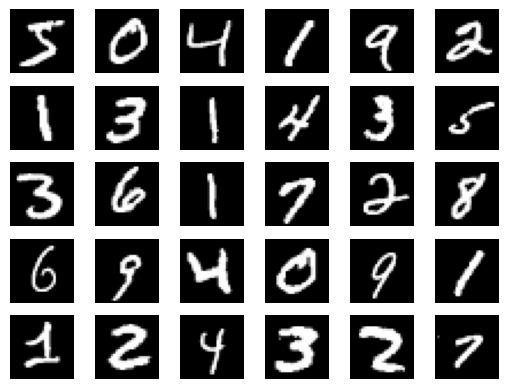

In [ ]:
# Load MNIST data: get_MNIST_data()
train_x, train_y, test_x, test_y = get_MNIST_data()
# Plot the first 20 images of the training set.
plot_images(train_x[0:30, :])

## run_linear_regression_on_MNIST

In [ ]:
lambda_factor=[1,0.1,0.01,0.001]
# we need to first define  run_linear_regression_on_MNIST  - function
for lmd in lambda_factor:
    test_error = run_linear_regression_on_MNIST(lambda_factor=lmd)
    print('Linear regression:- lambda: {:.4f}\t test_error: {:.4f}'.format(lmd,test_error))



Linear regression:- lambda: 1.0000	 test_error: 0.7697
Linear regression:- lambda: 0.1000	 test_error: 0.7698
Linear regression:- lambda: 0.0100	 test_error: 0.7702
Linear regression:- lambda: 0.0010	 test_error: 0.7702


## SVM

In [ ]:
print('SVM one vs. rest test_error:{:.4f}'.format(run_svm_one_vs_rest_on_MNIST()))

SVM one vs. rest test_error:0.0075


In [ ]:
print('Multiclass SVM test_error:{:.4f}'.format(run_multiclass_svm_on_MNIST()))

Multiclass SVM test_error:0.0818


## Soft max

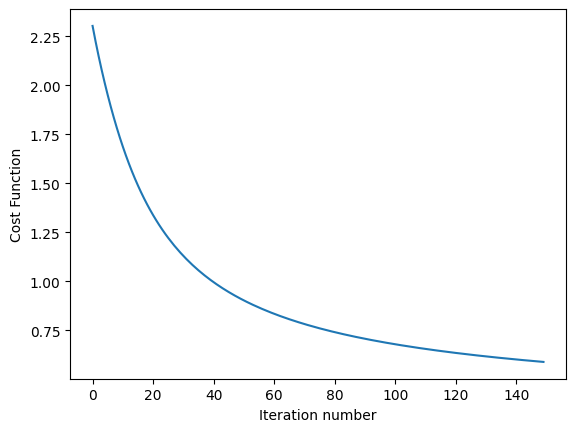

softmax_test_error_mod3= 0.09770000000000001
softmax test_error= 0.126


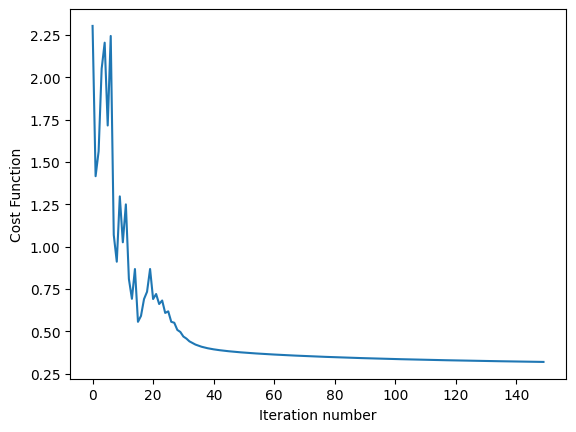

softmax_test_error_mod3= 0.06420000000000003
softmax test_error= 0.08389999999999997


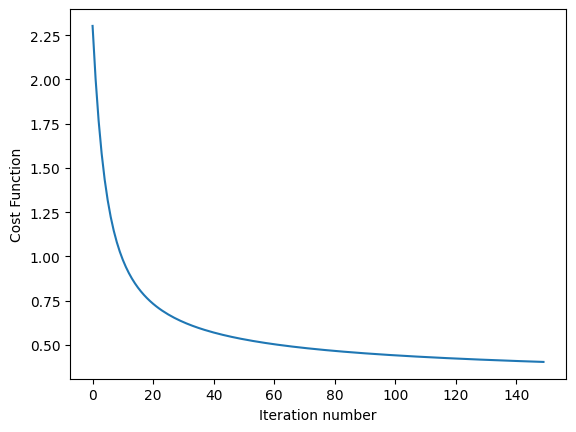

softmax_test_error_mod3= 0.07679999999999998
softmax test_error= 0.10050000000000003


In [ ]:
print('softmax test_error=', run_softmax_on_MNIST(temp_parameter=2))
print('softmax test_error=', run_softmax_on_MNIST(temp_parameter=0.5))
print('softmax test_error=', run_softmax_on_MNIST(temp_parameter=1))

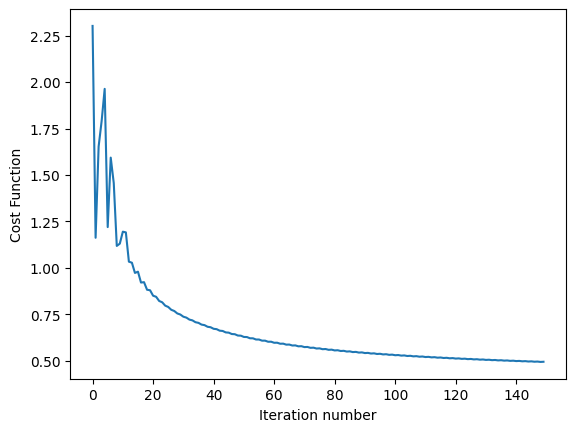

softmax_test_error_mod3= 0.1884
softmax test_error_mod3= 0.1884


In [ ]:
print('softmax test_error_mod3=', run_softmax_on_MNIST_mod3(temp_parameter=1))

## PCA

Dimensionality reduction via PCA

Classification Using Manually Crafted Features

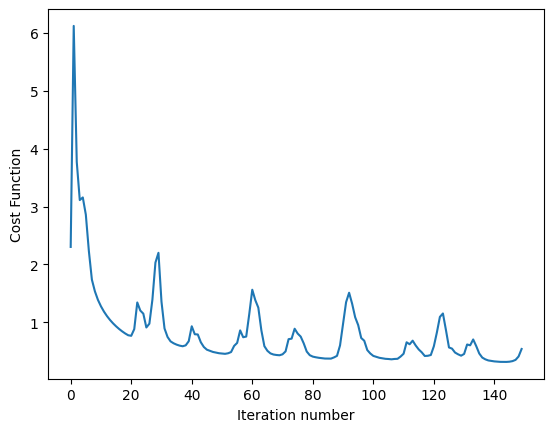

.......test error->train_pca10-> 0.10450000000000004
....... 0.20299999999999996


In [43]:
n_components = 10#18
pcs = principal_components(train_x)
#.... comment this when not using cubic feture, but using 18 dimencion pca
train_pca10 = cubic_features(project_onto_PC(train_x, pcs, n_components))
#.... comment this when not using cubic feture, but using 18 dimencion pca
test_pca10 = cubic_features(project_onto_PC(test_x, pcs, n_components))

# train_pca = project_onto_PC(train_x, pcs, n_components) #..... uncomment this when using 18 dim
# test_pca = project_onto_PC(test_x, pcs, n_components)   #..... uncomment this when using 18 dim

'''
# train_pca (and test_pca) is a representation of our training (and test) data
# after projecting each example onto the first 18 principal components.
'''
theta2, cost_function_history1 = softmax_regression(train_pca10, train_y, temp_parameter=1, alpha= 0.3, lambda_factor = 1.0e-4, k = 10, num_iterations = 150)
plot_cost_function_over_time(cost_function_history1)
test_error2 = compute_test_error(test_pca10, test_y, theta2, temp_parameter=1)
print('.......test error->train_pca10->',test_error2)

'''
 TODO: Train your softmax regression model using (train_pca, train_y)
       and evaluate its accuracy on (test_pca, test_y).
'''
# theta1, cost_function_history = softmax_regression(test_pca, test_y, temp_parameter=1, alpha= 0.3, lambda_factor = 1.0e-4, k = 10, num_iterations = 150)
# test_error1 = compute_test_error(test_pca, test_y, theta1, temp_parameter=1)
# print('.......',test_error1)



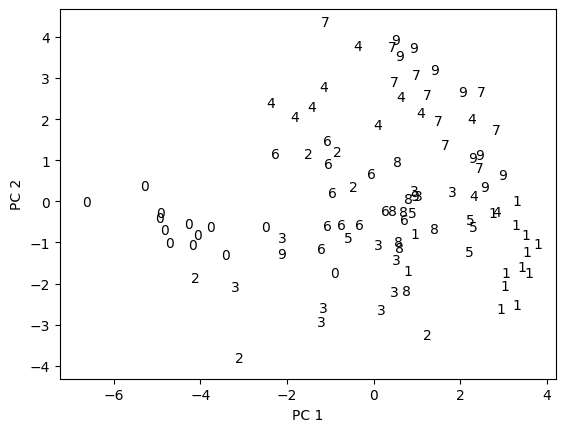

In [44]:
'''
# TODO: Use the plot_PC function in features.py to produce scatterplot
# of the first 100 MNIST images, as represented in the space spanned by the
# first 2 principal components found above.
'''
plot_PC(train_x[range(100),], pcs, train_y[range(100)])

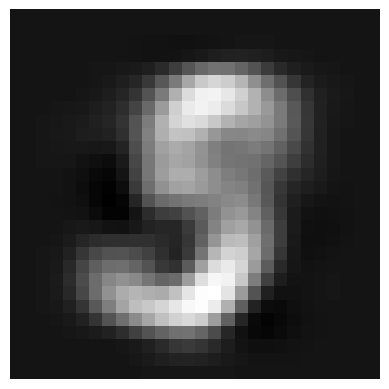

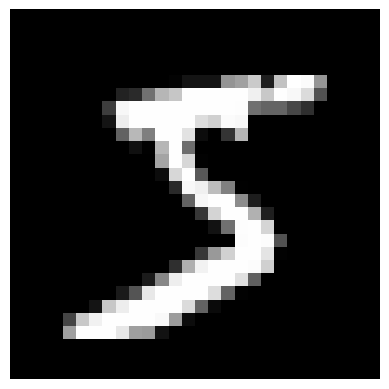

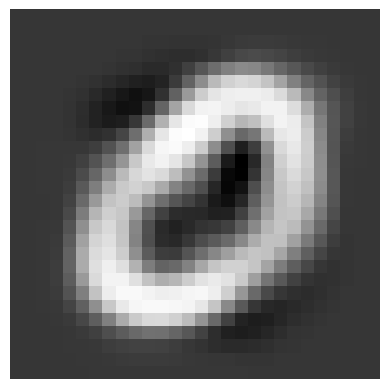

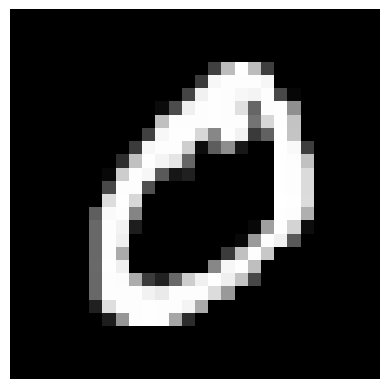

In [41]:
'''
# TODO: Use the reconstruct_PC function in features.py to show
# the first and second MNIST images as reconstructed solely from
# their 18-dimensional principal component representation.
# Compare the reconstructed images with the originals.
'''

firstimage_reconstructed = reconstruct_PC(train_pca[0, ], pcs, n_components, train_x)
plot_images(firstimage_reconstructed)
plot_images(train_x[0,])

secondimage_reconstructed = reconstruct_PC(train_pca[1, ], pcs, n_components, train_x)
plot_images(secondimage_reconstructed)
plot_images(train_x[1,])

In [ ]:
## Cubic Kernel ##
# TODO: Find the 10-dimensional PCA representation of the training and test set


# TODO: First fill out cubicFeatures() function in features.py as the below code requires it.

train_cube = cubic_features(train_pca10)
test_cube = cubic_features(test_pca10)
# train_cube (and test_cube) is a representation of our training (and test) data
# after applying the cubic kernel feature mapping to the 10-dimensional PCA representations.


# TODO: Train your softmax regression model using (train_cube, train_y)
#       and evaluate its accuracy on (test_cube, test_y).